### Starting spark session

In [112]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("BDPP_Project_AbhishekPulicherla") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [113]:
'''#IBM Watson
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-434388b1-5748-4a66-b404-f5dc7ddee862',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'vLHUwEerIw6PKeLgGS7NknmatrElAXaetSHSj07N9v_D'
}

configuration_name = 'os_5948e2b860cf482b9ab3c228994f1984_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
ccdefault = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('ccdefault.csv', 'bdppproject-donotdelete-pr-8acglkov1ykjrh'))
ccdefault.take(5)'''


"#IBM Watson\nimport ibmos2spark\n# @hidden_cell\ncredentials = {\n    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',\n    'service_id': 'iam-ServiceId-434388b1-5748-4a66-b404-f5dc7ddee862',\n    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',\n    'api_key': 'vLHUwEerIw6PKeLgGS7NknmatrElAXaetSHSj07N9v_D'\n}\n\nconfiguration_name = 'os_5948e2b860cf482b9ab3c228994f1984_configs'\ncos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')\n\nfrom pyspark.sql import SparkSession\nspark = SparkSession.builder.getOrCreate()\nccdefault = spark.read  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')  .option('header', 'true')  .load(cos.url('ccdefault.csv', 'bdppproject-donotdelete-pr-8acglkov1ykjrh'))\nccdefault.take(5)"


### Importing libraries

In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, HiveContext
from pyspark.sql import functions as F

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.regression import LinearRegression


from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [115]:
ccdefault = spark.read.load("ccdefault.csv",format="csv", sep=",", inferSchema="true", header="true")

In [116]:
#ccdefault = spark.read.load("gs://bdpp-project/ccdefault.csv",format="csv", sep=",", inferSchema="true", header="true")

### Features of the dataset

In [117]:
ccdefault.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: integer (nullable = true)
 |-- BILL_AMT2: integer (nullable = true)
 |-- BILL_AMT3: integer (nullable = true)
 |-- BILL_AMT4: integer (nullable = true)
 |-- BILL_AMT5: integer (nullable = true)
 |-- BILL_AMT6: integer (nullable = true)
 |-- PAY_AMT1: integer (nullable = true)
 |-- PAY_AMT2: integer (nullable = true)
 |-- PAY_AMT3: integer (nullable = true)
 |-- PAY_AMT4: integer (nullable = true)
 |-- PAY_AMT5: integer (nullable = true)
 |-- PAY_AMT6: integer (nullable = true)
 |-- DEFAULT: integer (nullable = tru

### Checking for missing values

In [118]:
#checking for missing values
from pyspark.sql.functions import when, count, col
ccdefault.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ccdefault.columns]).show()

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|DEFAULT|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
|  0|        0|  0|        0|       0|  0|    0|    0|    0|    0|    0|    0|        0|        0|        0|        0|        0|        0|       0|       0|       0|       0|       0|       0|      0|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+----

In [119]:
'''# Checking for missing values 
df=ccdefault.toPandas()
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()'''

"# Checking for missing values \ndf=ccdefault.toPandas()\ntotal = df.isnull().sum().sort_values(ascending = False)\npercent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)\npd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()"

In [120]:
# Printing the Default column
print(ccdefault.select("ID","DEFAULT").show(5))

+---+-------+
| ID|DEFAULT|
+---+-------+
|  1|      1|
|  2|      1|
|  3|      0|
|  4|      0|
|  5|      0|
+---+-------+
only showing top 5 rows

None


### Checking for class imbalance

In [121]:
print("Default == 1:", ccdefault.filter(ccdefault.DEFAULT == 1).count())
print("Default == 0:", ccdefault.filter(ccdefault.DEFAULT == 0).count())

Default == 1: 6636
Default == 0: 23364


In [122]:
df=ccdefault.toPandas()

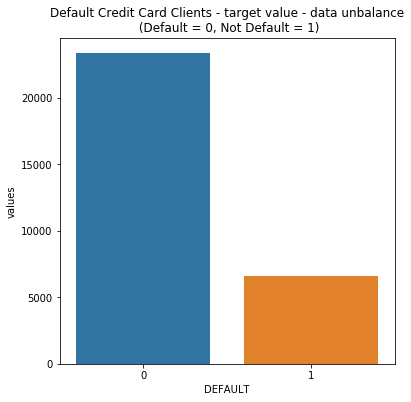

In [123]:
import seaborn as sns
import matplotlib.pylab as plt

temp = df["DEFAULT"].value_counts()
df1 = pd.DataFrame({'DEFAULT': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Default Credit Card Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'DEFAULT', y="values", data=df1)
locs, labels = plt.xticks()
plt.show()

### Drop ID column

In [124]:
#drop ID column
data = ccdefault.select(ccdefault.schema.names[1:])

In [125]:
data.take(5)

[Row(LIMIT_BAL=20000, SEX=2, EDUCATION=2, MARRIAGE=1, AGE=24, PAY_0=2, PAY_2=2, PAY_3=-1, PAY_4=-1, PAY_5=-2, PAY_6=-2, BILL_AMT1=3913, BILL_AMT2=3102, BILL_AMT3=689, BILL_AMT4=0, BILL_AMT5=0, BILL_AMT6=0, PAY_AMT1=0, PAY_AMT2=689, PAY_AMT3=0, PAY_AMT4=0, PAY_AMT5=0, PAY_AMT6=0, DEFAULT=1),
 Row(LIMIT_BAL=120000, SEX=2, EDUCATION=2, MARRIAGE=2, AGE=26, PAY_0=-1, PAY_2=2, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=2, BILL_AMT1=2682, BILL_AMT2=1725, BILL_AMT3=2682, BILL_AMT4=3272, BILL_AMT5=3455, BILL_AMT6=3261, PAY_AMT1=0, PAY_AMT2=1000, PAY_AMT3=1000, PAY_AMT4=1000, PAY_AMT5=0, PAY_AMT6=2000, DEFAULT=1),
 Row(LIMIT_BAL=90000, SEX=2, EDUCATION=2, MARRIAGE=2, AGE=34, PAY_0=0, PAY_2=0, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=0, BILL_AMT1=29239, BILL_AMT2=14027, BILL_AMT3=13559, BILL_AMT4=14331, BILL_AMT5=14948, BILL_AMT6=15549, PAY_AMT1=1518, PAY_AMT2=1500, PAY_AMT3=1000, PAY_AMT4=1000, PAY_AMT5=1000, PAY_AMT6=5000, DEFAULT=0),
 Row(LIMIT_BAL=50000, SEX=2, EDUCATION=2, MARRIAGE=1, AGE=37, PAY_0=0, PAY_2=0

In [126]:
'''#IBM Watson

data = data.withColumn('LIMIT_BAL', data.LIMIT_BAL.cast('int'))
data = data.withColumn('SEX', data.SEX.cast('int'))
data = data.withColumn('EDUCATION', data.EDUCATION.cast('int'))
data = data.withColumn('MARRIAGE', data.MARRIAGE.cast('int'))
data = data.withColumn('AGE', data.AGE.cast('int'))
data = data.withColumn('PAY_0', data.PAY_0.cast('int'))
data = data.withColumn('PAY_2', data.PAY_2.cast('int'))
data = data.withColumn('PAY_3', data.PAY_3.cast('int'))
data = data.withColumn('PAY_4', data.PAY_4.cast('int'))
data = data.withColumn('PAY_5', data.PAY_5.cast('int'))
data = data.withColumn('PAY_6', data.PAY_6.cast('int'))
data = data.withColumn('BILL_AMT1', data.BILL_AMT1.cast('int'))

data = data.withColumn('BILL_AMT2', data.BILL_AMT2.cast('int'))
data = data.withColumn('BILL_AMT3', data.BILL_AMT3.cast('int'))
data = data.withColumn('BILL_AMT4', data.BILL_AMT4.cast('int'))
data = data.withColumn('BILL_AMT5', data.BILL_AMT5.cast('int'))
data = data.withColumn('BILL_AMT6', data.BILL_AMT6.cast('int'))
data = data.withColumn('PAY_AMT1', data.PAY_AMT1.cast('int'))
data = data.withColumn('PAY_AMT2', data.PAY_AMT2.cast('int'))

data = data.withColumn('PAY_AMT3', data.PAY_AMT3.cast('int'))
data = data.withColumn('PAY_AMT4', data.PAY_AMT4.cast('int'))
data = data.withColumn('PAY_AMT5', data.PAY_AMT5.cast('int'))
data = data.withColumn('PAY_AMT6', data.PAY_AMT6.cast('int'))'''


"#IBM Watson\n\ndata = data.withColumn('LIMIT_BAL', data.LIMIT_BAL.cast('int'))\ndata = data.withColumn('SEX', data.SEX.cast('int'))\ndata = data.withColumn('EDUCATION', data.EDUCATION.cast('int'))\ndata = data.withColumn('MARRIAGE', data.MARRIAGE.cast('int'))\ndata = data.withColumn('AGE', data.AGE.cast('int'))\ndata = data.withColumn('PAY_0', data.PAY_0.cast('int'))\ndata = data.withColumn('PAY_2', data.PAY_2.cast('int'))\ndata = data.withColumn('PAY_3', data.PAY_3.cast('int'))\ndata = data.withColumn('PAY_4', data.PAY_4.cast('int'))\ndata = data.withColumn('PAY_5', data.PAY_5.cast('int'))\ndata = data.withColumn('PAY_6', data.PAY_6.cast('int'))\ndata = data.withColumn('BILL_AMT1', data.BILL_AMT1.cast('int'))\n\ndata = data.withColumn('BILL_AMT2', data.BILL_AMT2.cast('int'))\ndata = data.withColumn('BILL_AMT3', data.BILL_AMT3.cast('int'))\ndata = data.withColumn('BILL_AMT4', data.BILL_AMT4.cast('int'))\ndata = data.withColumn('BILL_AMT5', data.BILL_AMT5.cast('int'))\ndata = data.with

### Data Description

In [127]:
data.describe(['LIMIT_BAL','AGE']).show()

+-------+------------------+-----------------+
|summary|         LIMIT_BAL|              AGE|
+-------+------------------+-----------------+
|  count|             30000|            30000|
|   mean|167484.32266666667|          35.4855|
| stddev|129747.66156720246|9.217904068090155|
|    min|             10000|               21|
|    max|           1000000|               79|
+-------+------------------+-----------------+



### Data Cleaning

In [128]:
#removing the unecessary labels in education column
fil = (df.EDUCATION == 5) | (df.EDUCATION == 6) | (df.EDUCATION == 0)
df.loc[fil, 'EDUCATION'] = 4
df.EDUCATION.value_counts()

2    14030
1    10585
3     4917
4      468
Name: EDUCATION, dtype: int64

In [129]:
#removing the unecessary labels in marriage column
df.loc[df.MARRIAGE == 0, 'MARRIAGE'] = 3
df.MARRIAGE.value_counts()

2    15964
1    13659
3      377
Name: MARRIAGE, dtype: int64

In [130]:
data = spark.createDataFrame(df)

In [131]:
# correcting the pay column wrongly named
data = data.withColumnRenamed("PAY_0", "PAY_1")
data.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|DEFAULT|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|      1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|     3455|     3261|       0|    1000|    1000|    1000|       0|    2000|    

### Exploring the data

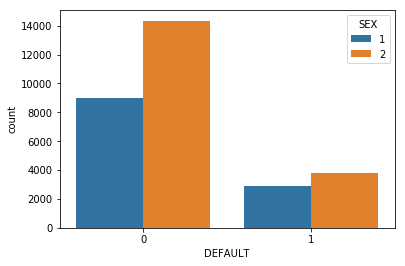

In [132]:
# Comparing default rate with both the sexes 
ds = sns.countplot(x="DEFAULT",hue="SEX", data=df)
plt.show()

Merging categories in EDUCATION column

In [133]:
df.loc[(df.EDUCATION == 5)|(df.EDUCATION == 0)|
                 (df.EDUCATION == 6),'EDUCATION']=4

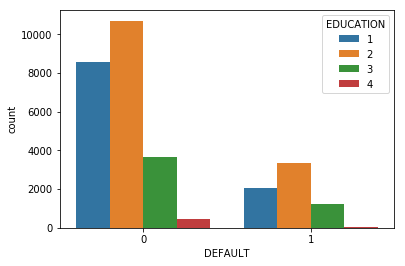

In [134]:
de = sns.countplot(x="DEFAULT",hue="EDUCATION",data=df)
plt.show()

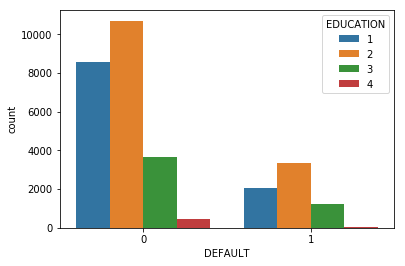

In [135]:
de = sns.countplot(x="DEFAULT",hue="EDUCATION",data=df)
plt.show()

### Feature Correlation for some features

In [136]:
#Comparing Sex and Default columns
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["SEX","DEFAULT"],
    outputCol="features_1")

Attrs_1 = assembler.transform(data)
Attrs_1.select("features_1").show(5)

+----------+
|features_1|
+----------+
| [2.0,1.0]|
| [2.0,1.0]|
| [2.0,0.0]|
| [2.0,0.0]|
| [1.0,0.0]|
+----------+
only showing top 5 rows



In [137]:
# Correlation for Sex and Default
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

cor_mat = Correlation.corr(Attrs_1, "features_1").head()

print("correlation matrix:\n" + str(cor_mat[0]))

correlation matrix:
DenseMatrix([[ 1.        , -0.03996058],
             [-0.03996058,  1.        ]])


In [138]:
#Comparing Marriage and Default columns
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["MARRIAGE","DEFAULT"],
    outputCol="features_2")

Attrs_2 = assembler.transform(data)
Attrs_2.select("features_2").show(5)

+----------+
|features_2|
+----------+
| [1.0,1.0]|
| [2.0,1.0]|
| [2.0,0.0]|
| [1.0,0.0]|
| [1.0,0.0]|
+----------+
only showing top 5 rows



In [139]:
# Correlation for Marriage and Default
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

cor_mat_2 = Correlation.corr(Attrs_2, "features_2").head()

print("correlation matrix:\n" + str(cor_mat_2[0]))

correlation matrix:
DenseMatrix([[ 1.        , -0.02757471],
             [-0.02757471,  1.        ]])


In [140]:
#Comparing Age and Default columns
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["AGE","DEFAULT"],
    outputCol="features_3")

Attrs_3 = assembler.transform(data)
Attrs_3.select("features_3").show(5)

+----------+
|features_3|
+----------+
|[24.0,1.0]|
|[26.0,1.0]|
|[34.0,0.0]|
|[37.0,0.0]|
|[57.0,0.0]|
+----------+
only showing top 5 rows



In [141]:
# Correlation for Age and Default
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

cor_mat_3 = Correlation.corr(Attrs_3, "features_3").head()

print("correlation matrix:\n" + str(cor_mat_3[0]))

correlation matrix:
DenseMatrix([[1.        , 0.01388983],
             [0.01388983, 1.        ]])


In [142]:
''' Split data into training and test sample
splits = data.randomSplit([0.75, 0.25])
data_train_int = splits[0]
data_test = splits[1]'''

' Split data into training and test sample\nsplits = data.randomSplit([0.75, 0.25])\ndata_train_int = splits[0]\ndata_test = splits[1]'

In [143]:
data.take(5)

[Row(ID=1, LIMIT_BAL=20000, SEX=2, EDUCATION=2, MARRIAGE=1, AGE=24, PAY_1=2, PAY_2=2, PAY_3=-1, PAY_4=-1, PAY_5=-2, PAY_6=-2, BILL_AMT1=3913, BILL_AMT2=3102, BILL_AMT3=689, BILL_AMT4=0, BILL_AMT5=0, BILL_AMT6=0, PAY_AMT1=0, PAY_AMT2=689, PAY_AMT3=0, PAY_AMT4=0, PAY_AMT5=0, PAY_AMT6=0, DEFAULT=1),
 Row(ID=2, LIMIT_BAL=120000, SEX=2, EDUCATION=2, MARRIAGE=2, AGE=26, PAY_1=-1, PAY_2=2, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=2, BILL_AMT1=2682, BILL_AMT2=1725, BILL_AMT3=2682, BILL_AMT4=3272, BILL_AMT5=3455, BILL_AMT6=3261, PAY_AMT1=0, PAY_AMT2=1000, PAY_AMT3=1000, PAY_AMT4=1000, PAY_AMT5=0, PAY_AMT6=2000, DEFAULT=1),
 Row(ID=3, LIMIT_BAL=90000, SEX=2, EDUCATION=2, MARRIAGE=2, AGE=34, PAY_1=0, PAY_2=0, PAY_3=0, PAY_4=0, PAY_5=0, PAY_6=0, BILL_AMT1=29239, BILL_AMT2=14027, BILL_AMT3=13559, BILL_AMT4=14331, BILL_AMT5=14948, BILL_AMT6=15549, PAY_AMT1=1518, PAY_AMT2=1500, PAY_AMT3=1000, PAY_AMT4=1000, PAY_AMT5=1000, PAY_AMT6=5000, DEFAULT=0),
 Row(ID=4, LIMIT_BAL=50000, SEX=2, EDUCATION=2, MARRIAGE=1, 

### Blind Machine Learning

In [144]:
# Vector Assembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

va2 = VectorAssembler(inputCols = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'], outputCol ='final_features' )

temp1 = va2.transform(data)
dataset = temp1.withColumn('features', temp1.final_features)
dataset = dataset.withColumnRenamed( 'DEFAULT', 'label')

In [145]:
dataset = dataset.select("features", 'label')
dataset.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[20000.0,2.0,2.0,...|    1|
|[120000.0,2.0,2.0...|    1|
|[90000.0,2.0,2.0,...|    0|
|[50000.0,2.0,2.0,...|    0|
|[50000.0,1.0,2.0,...|    0|
+--------------------+-----+
only showing top 5 rows



In [146]:
#Data Split
trainSet, testSet = dataset.randomSplit([.8,.2],1)

In [147]:
from timeit import default_timer as timer

In [162]:
# Logistic Regression 
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
start = timer()
lrModel = lr.fit(trainSet)
end = timer()
#%timeit lr.fit(trainSet)
trainingSummary = lrModel.summary
predictions= lrModel.transform(testSet)

print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))
print("Time="+str(end-start))

Coefficients: [-5.808408746981282e-07,-0.06213347394136609,-0.08364019039476711,-0.04337384130260418,0.012738919963658545,0.5689608994758744,0.11994038089814613,0.06716883845297263,0.015998578418654694,0.02386180811775111,0.020286837487802988,-1.2082932970865753e-06,-6.164988633136727e-07,-2.1244732785279912e-07,8.245601476319846e-08,4.179753767808766e-07,5.58083714906645e-07,-8.163593166405838e-06,-6.914964954890008e-06,-4.872073876989191e-06,-4.44968767146017e-06,-5.430440397134542e-06,-2.952970791031161e-06]
Intercept: -1.2083635577266096
Time=4.176971599999888


In [149]:
predictions.select( 'label', 'prediction', 'probability').show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    0|       0.0|[0.73771054929694...|
|    1|       0.0|[0.73179407788977...|
|    0|       0.0|[0.75207139671125...|
|    0|       0.0|[0.92967713320346...|
|    1|       0.0|[0.77919757806050...|
+-----+----------+--------------------+
only showing top 5 rows



In [150]:
'''trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnder ROC: ' + str(trainingSummary.areaUnderROC))'''

"trainingSummary = lrModel.summary\n\nroc = trainingSummary.roc.toPandas()\nplt.plot(roc['FPR'],roc['TPR'])\nplt.ylabel('False Positive Rate')\nplt.xlabel('True Positive Rate')\nplt.title('ROC Curve')\nplt.show()\n\nprint('Training set areaUnder ROC: ' + str(trainingSummary.areaUnderROC))"

In [151]:
# Test Area Under ROC for LR
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7174356786132999


In [152]:
accuracy = MulticlassClassificationEvaluator(
    labelCol = "label", predictionCol = "prediction", metricName = "accuracy")
precision = MulticlassClassificationEvaluator(
    labelCol = "label", predictionCol = "prediction", metricName = "weightedPrecision")
recall = MulticlassClassificationEvaluator(
    labelCol = "label", predictionCol = "prediction", metricName = "weightedRecall")

In [153]:
# For LR
print("Accuracy: {:.4}".format(accuracy.evaluate(predictions)))
print("Weighted precision: {:.4}".format(precision.evaluate(predictions)))
print(" Weighted recall: {:.4}".format(recall.evaluate(predictions)))

Accuracy: 0.8145
Weighted precision: 0.8002
 Weighted recall: 0.8145


In [163]:
#Random Forest Classifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label') 
start = timer()
rfModel = rf.fit(trainSet)
end = timer()
#trainingSummary_rf = rfModel.summary
predictions_rf= rfModel.transform(testSet)

print("Time="+str(end-start))

#predictions_rf = rfModel.transform(testSet)
#predictions = rfModel.transform(testSet)

Time=19.590058300000237


In [158]:
# Area under ROC
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7607448455444648


In [159]:
#For RF
print("Accuracy: {:.4}".format(accuracy.evaluate(predictions_rf)))
print("Weighted precision: {:.4}".format(precision.evaluate(predictions_rf)))
print(" Weighted recall: {:.4}".format(recall.evaluate(predictions_rf)))

Accuracy: 0.8202
Weighted precision: 0.8024
 Weighted recall: 0.8202


In [160]:
print (rfModel.featureImportances)

(23,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22],[0.0027970183932421993,0.00037843421916088527,0.0014581523877568985,0.00025847361485827427,0.003819968798019249,0.4465554144724321,0.21338883425411911,0.1521229098171827,0.07338292088371051,0.035163533763677986,0.00847687106695431,0.0049873886852266295,0.006223087207010829,0.003993056625592918,0.0021045719129836795,0.002722483122541242,0.00379067013085401,0.00950204670930615,0.013582904535780288,0.0055678827401171435,0.004475139742814055,0.002984684275445515,0.00226355264121341])


In [164]:
# Linear Support Vector Classifier
lsvc = LinearSVC(labelCol = "label", featuresCol = "features", maxIter=10, regParam=0.1)
start = timer()
model_lsvc=lsvc.fit(trainSet)
end = timer()
predictions_lsvc=model_lsvc.transform(testSet)
print("Time="+str(end-start))

Time=97.62070959999983


In [165]:
# Area Under ROC
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_lsvc, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.684027908227049


In [167]:
# For LSVC
print("Accuracy: {:.4}".format(accuracy.evaluate(predictions_lsvc)))
print("Weighted precision: {:.4}".format(precision.evaluate(predictions_lsvc)))
print(" Weighted recall: {:.4}".format(recall.evaluate(predictions_lsvc)))

Accuracy: 0.7816
Weighted precision: 0.8293
 Weighted recall: 0.7816


### ML after Feature Engineering

### One hot Encoding

In [168]:
from pyspark.ml.feature import OneHotEncoderEstimator
encoder = OneHotEncoderEstimator(inputCols=["SEX","EDUCATION","MARRIAGE"],outputCols=["SEX_vec","EDUCATION_vec","MARRIAGE_vec"])

model = encoder.fit(data)
mod_hot = model.transform(data)
mod_hot.select("SEX","MARRIAGE","EDUCATION").take(5)

[Row(SEX=2, MARRIAGE=1, EDUCATION=2),
 Row(SEX=2, MARRIAGE=2, EDUCATION=2),
 Row(SEX=2, MARRIAGE=2, EDUCATION=2),
 Row(SEX=2, MARRIAGE=1, EDUCATION=2),
 Row(SEX=1, MARRIAGE=1, EDUCATION=2)]

In [169]:
# Get and convert categorical features (SEX, EDUCATION, MARRIAGE)
'''categorical_features = data.schema.names[1:4]
catVect = VectorAssembler(inputCols = categorical_features, outputCol = "catFeatures")
catIdx = VectorIndexer(inputCol = catVect.getOutputCol(), outputCol = "idxCatFeatures")'''


'categorical_features = data.schema.names[1:4]\ncatVect = VectorAssembler(inputCols = categorical_features, outputCol = "catFeatures")\ncatIdx = VectorIndexer(inputCol = catVect.getOutputCol(), outputCol = "idxCatFeatures")'

In [170]:
'''categorical_features1 = data.schema.names[5:11]
catVect1 = VectorAssembler(inputCols = categorical_features1, outputCol = "catFeatures1")
catIdx1 = VectorIndexer(inputCol = catVect1.getOutputCol(), outputCol = "idxCatFeatures1")'''

'categorical_features1 = data.schema.names[5:11]\ncatVect1 = VectorAssembler(inputCols = categorical_features1, outputCol = "catFeatures1")\ncatIdx1 = VectorIndexer(inputCol = catVect1.getOutputCol(), outputCol = "idxCatFeatures1")'

In [171]:
# Get and normalize numerical features
#numerical_features = data.schema.names[0:1]+data.schema.names[4:]
'''numVect = VectorAssembler(inputCols = ['LIMIT_BAL', 'AGE',
 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'], outputCol = "numFeatures")
minMax = MinMaxScaler(inputCol = numVect.getOutputCol(), outputCol = "normFeatures")'''

'numVect = VectorAssembler(inputCols = [\'LIMIT_BAL\', \'AGE\',\n \'PAY_0\', \'PAY_2\', \'PAY_3\', \'PAY_4\', \'PAY_5\', \'PAY_6\', \'BILL_AMT1\', \'BILL_AMT2\',\n \'BILL_AMT3\', \'BILL_AMT4\', \'BILL_AMT5\', \'BILL_AMT6\', \'PAY_AMT1\', \'PAY_AMT2\', \'PAY_AMT3\',\n \'PAY_AMT4\', \'PAY_AMT5\', \'PAY_AMT6\'], outputCol = "numFeatures")\nminMax = MinMaxScaler(inputCol = numVect.getOutputCol(), outputCol = "normFeatures")'

In [172]:
# Vector Assembler
from pyspark.ml.feature import StandardScaler
#numerical_features = data.schema.names[0:1]+data.schema.names[4:]
numVect = VectorAssembler(inputCols = ['LIMIT_BAL', 'AGE',
 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'], outputCol = "numFeatures")
StdScl= StandardScaler(inputCol = numVect.getOutputCol(), outputCol = "normFeatures")

In [173]:
# Data Pipeline

from pyspark.ml import Pipeline

numPipeline = Pipeline(stages=[numVect,StdScl])
catPipeline = Pipeline(stages=[encoder])
pipeline = Pipeline(stages=[catPipeline,numPipeline])
new_def = pipeline.fit(data).transform(data)
new_def.show(1)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+---------+-------------+-------------+--------------------+--------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|DEFAULT|  SEX_vec|EDUCATION_vec| MARRIAGE_vec|         numFeatures|        normFeatures|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+---------+-------------+-------------+--------------------+--------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689| 

In [174]:
#new_def.groupby('label').count().toPandas()

In [175]:
va_data = VectorAssembler(inputCols=["SEX_vec","EDUCATION_vec","MARRIAGE_vec","normFeatures"], outputCol='final_feat')

mod_va = va_data.transform(new_def)
#temp1.show(5)
data_pipe = mod_va.withColumn("features", mod_va.final_feat).select("features",col("DEFAULT").alias("label"))
data_pipe.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(29,[4,7,9,10,11,...|    1|
|(29,[4,8,9,10,11,...|    1|
|(29,[4,8,9,10,17,...|    0|
|(29,[4,7,9,10,17,...|    0|
|[0.0,1.0,0.0,0.0,...|    0|
+--------------------+-----+
only showing top 5 rows



In [176]:
#new_def.toPandas()

In [177]:
# Define pipeline 
'''featVect = VectorAssembler(inputCols=["idxCatFeatures","normFeatures","SEX_vec","EDUCATION_vec","MARRIAGE_vec"], outputCol = "features")
pipeline = Pipeline(stages = [numVect, minMax, featVect,mod_hot])
pipeline_object = pipeline.fit(datatrain_up)'''

'featVect = VectorAssembler(inputCols=["idxCatFeatures","normFeatures","SEX_vec","EDUCATION_vec","MARRIAGE_vec"], outputCol = "features")\npipeline = Pipeline(stages = [numVect, minMax, featVect,mod_hot])\npipeline_object = pipeline.fit(datatrain_up)'

In [178]:
'''# Run training and test data through the pipeline
data_train = pipeline_object.transform(new_def).select("features", col("DEFAULT").alias("label"))
data_test = pipeline_object.transform(data_test).select("features", col("DEFAULT").alias("label"))'''

'# Run training and test data through the pipeline\ndata_train = pipeline_object.transform(new_def).select("features", col("DEFAULT").alias("label"))\ndata_test = pipeline_object.transform(data_test).select("features", col("DEFAULT").alias("label"))'

In [179]:
# Data Split
train_data, test_data = data_pipe.randomSplit([0.8, 0.2], seed=12345)

In [180]:
train_data.groupby('label').count().toPandas()

,label,count
0,0,18601
1,1,5327


In [181]:
# Logistic Regression
lr1 = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
start = timer()
lrModel1 = lr1.fit(train_data)
end = timer()
trainingSummary = lrModel1.summary
predictions= lrModel1.transform(test_data)

print("Coefficients: %s" % str(lrModel1.coefficients))
print("Intercept: %s" % str(lrModel1.intercept))
print("Time="+str(end-start))

Coefficients: [0.0,0.08925289003911029,0.0,0.1641322735685014,0.08811872022845503,0.09170650068082202,0.0,0.0786563492294813,-0.12034807247790759,-0.11617676289018297,0.030280858346908805,0.661864044221762,0.0838807417481531,0.06979265281142912,0.020548058298997578,0.03876922664775436,0.027822796329217466,-0.14184670106747496,-0.03605823815275668,-0.013006010788815432,0.03318414059227879,0.05508994706468222,0.04076696633719045,-0.1636255077382878,-0.2308628423494698,-0.05986673473680814,-0.06612769485138047,-0.05976597585367703,-0.012612855544574059]
Intercept: -1.2670576343626985
Time=4.532262700000501


In [182]:
# For LR
print("Accuracy: {:.4}".format(accuracy.evaluate(predictions)))
print("Weighted precision: {:.4}".format(precision.evaluate(predictions)))
print(" Weighted recall: {:.4}".format(recall.evaluate(predictions)))

Accuracy: 0.8151
Weighted precision: 0.7977
 Weighted recall: 0.8151


In [183]:
# Area under ROC for LR
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7184002224942823


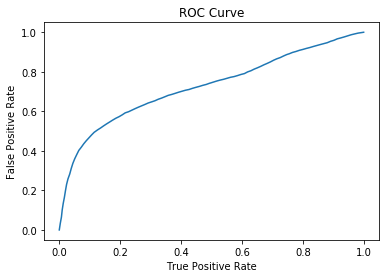

Training set areaUnder ROC: 0.7245011069859478


In [184]:
# Area under ROC Curve for LR
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnder ROC: ' + str(trainingSummary.areaUnderROC))

In [185]:
# Random Forest Classifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label') 
start = timer()
rfModel = rf.fit(train_data)
end = timer()
#trainingSummary_rf = rfModel.summary
predictions_rf= rfModel.transform(test_data)
print("Time="+str(end-start))

#predictions_rf = rfModel.transform(testSet)
#predictions = rfModel.transform(testSet)

Time=19.793643699999848


In [186]:
# For RF
print("Accuracy: {:.4}".format(accuracy.evaluate(predictions_rf)))
print("Weighted precision: {:.4}".format(precision.evaluate(predictions_rf)))
print(" Weighted recall: {:.4}".format(recall.evaluate(predictions_rf)))

Accuracy: 0.8154
Weighted precision: 0.7956
 Weighted recall: 0.8154


In [187]:
# Area under ROC for RF
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7662515696256174


In [188]:
# Linear Support Vector Classifier
lsvc = LinearSVC(labelCol = "label", featuresCol = "features", maxIter=10, regParam=0.1)
start = timer()
model_lsvc=lsvc.fit(train_data)
end = timer()
predictions_lsvc=model_lsvc.transform(test_data)
print("Time="+str(end-start))

Time=87.18944730000021


In [189]:
# For lsvc
print("Accuracy: {:.4}".format(accuracy.evaluate(predictions_lsvc)))
print("Weighted precision: {:.4}".format(precision.evaluate(predictions_lsvc)))
print(" Weighted recall: {:.4}".format(recall.evaluate(predictions_lsvc)))

Accuracy: 0.7877
Weighted precision: 0.7825
 Weighted recall: 0.7877


In [228]:
# Area under ROC for lsvc
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_lsvc, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7193759822800219


### ML with Upsampling(Pyspark)

In [229]:
from pyspark.sql.functions import col

train_up_1 = data.where(col('DEFAULT')==1).sample(True, 3.552, seed = 1000)

In [230]:
train_up_1.groupby('DEFAULT').count().toPandas()

,DEFAULT,count
0,1,23813


In [231]:
train_up_0= data.where(col('DEFAULT')==0)
datatrain_up = train_up_0.union(train_up_1)

In [232]:
datatrain_up.groupby('DEFAULT').count().toPandas()

,DEFAULT,count
0,0,23364
1,1,23813


In [233]:
from pyspark.ml.feature import OneHotEncoderEstimator
encoder = OneHotEncoderEstimator(inputCols=["SEX","EDUCATION","MARRIAGE"],outputCols=["SEX_vec","EDUCATION_vec","MARRIAGE_vec"])

model = encoder.fit(datatrain_up)
mod_hot = model.transform(datatrain_up)
mod_hot.select("SEX","MARRIAGE").take(5)

[Row(SEX=2, MARRIAGE=2),
 Row(SEX=2, MARRIAGE=1),
 Row(SEX=1, MARRIAGE=1),
 Row(SEX=1, MARRIAGE=2),
 Row(SEX=1, MARRIAGE=2)]

In [234]:
from pyspark.ml.feature import StandardScaler
#numerical_features = data.schema.names[0:1]+data.schema.names[4:]
numVect = VectorAssembler(inputCols = ['LIMIT_BAL', 'AGE',
 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'], outputCol = "numFeatures")
StdScl= StandardScaler(inputCol = numVect.getOutputCol(), outputCol = "normFeatures")

In [235]:
from pyspark.ml import Pipeline

numPipeline = Pipeline(stages=[numVect,StdScl])
catPipeline = Pipeline(stages=[encoder])
pipeline = Pipeline(stages=[catPipeline,numPipeline])
new_def = pipeline.fit(datatrain_up).transform(datatrain_up)
new_def.show(1)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+---------+-------------+-------------+--------------------+--------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|DEFAULT|  SEX_vec|EDUCATION_vec| MARRIAGE_vec|         numFeatures|        normFeatures|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+---------+-------------+-------------+--------------------+--------------------+
|  3|    90000|  2|        2|       2| 34|    0|    0|    0|    0|    0|    0|    29239|    14027|    13559|    14331|    14948|    15549|    1518|    1500| 

In [236]:
va_data = VectorAssembler(inputCols=["SEX_vec","EDUCATION_vec","MARRIAGE_vec","normFeatures"], outputCol='final_feat')

mod_va = va_data.transform(new_def)
#temp1.show(5)
data_pipe = mod_va.withColumn("features", mod_va.final_feat).select("features",col("DEFAULT").alias("label"))
data_pipe.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(29,[4,8,9,10,17,...|    0|
|(29,[4,7,9,10,17,...|    0|
|[0.0,1.0,0.0,0.0,...|    0|
|(29,[1,3,8,9,10,1...|    0|
|(29,[1,3,8,9,10,1...|    0|
+--------------------+-----+
only showing top 5 rows



In [237]:
#test_data.groupby('label').count().toPandas()

In [238]:
train_data, test_data = data_pipe.randomSplit([0.8, 0.2], seed=12345)

In [239]:
lr1 = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel1 = lr1.fit(train_data)
trainingSummary = lrModel1.summary
predictions= lrModel1.transform(test_data)

print("Coefficients: %s" % str(lrModel1.coefficients))
print("Intercept: %s" % str(lrModel1.intercept))

Coefficients: [0.0,0.08978615545013047,0.0,0.20248984910791706,0.12314071022146393,0.12339593992841323,0.0,0.04904871663383554,-0.14115221798284183,-0.09361194300265613,0.03263827939849309,0.6298196662564886,0.09737906893859212,0.09082762522291353,0.07060892198542143,0.022915776936709223,-0.0047278260627659965,-0.13422792104960937,-0.013875862224810053,-0.02241101442009721,0.0001620104703877837,0.04706758186121603,0.028499892596602763,-0.15553879025403097,-0.12547832648331006,-0.05437467162393016,-0.05835478887587911,-0.024849016970573706,-0.02028216756851355]
Intercept: -0.021219215334663984


In [240]:
print("Accuracy: {:.4}".format(accuracy.evaluate(predictions)))
print("Weighted precision: {:.4}".format(precision.evaluate(predictions)))
print(" Weighted recall: {:.4}".format(recall.evaluate(predictions)))

Accuracy: 0.6691
Weighted precision: 0.6692
 Weighted recall: 0.6691


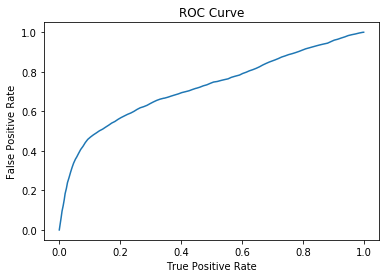

Training set areaUnder ROC: 0.7201038198785551


In [241]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnder ROC: ' + str(trainingSummary.areaUnderROC))

In [242]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7236349626202631


In [243]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label') 
rfModel = rf.fit(train_data)
#trainingSummary_rf = rfModel.summary
predictions_rf= rfModel.transform(test_data)

#predictions_rf = rfModel.transform(testSet)
#predictions = rfModel.transform(testSet)

In [244]:
print("Accuracy: {:.4}".format(accuracy.evaluate(predictions_rf)))
print("Weighted precision: {:.4}".format(precision.evaluate(predictions_rf)))
print(" Weighted recall: {:.4}".format(recall.evaluate(predictions_rf)))

Accuracy: 0.7171
Weighted precision: 0.7279
 Weighted recall: 0.7171


In [245]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.773887789108904


In [246]:
lsvc = LinearSVC(labelCol = "label", featuresCol = "features", maxIter=10, regParam=0.1)
model_lsvc=lsvc.fit(train_data)
predictions_lsvc=model_lsvc.transform(test_data)

In [247]:
print("Accuracy: {:.4}".format(accuracy.evaluate(predictions_lsvc)))
print("Weighted precision: {:.4}".format(precision.evaluate(predictions_lsvc)))
print(" Weighted recall: {:.4}".format(recall.evaluate(predictions_lsvc)))

Accuracy: 0.6744
Weighted precision: 0.6828
 Weighted recall: 0.6744


In [248]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_lsvc, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.719375982280022


### ML with Downsampling(Pyspark)

In [249]:
train_0_dwn = data.where(col('DEFAULT')==0).sample(True, 0.279, seed = 1000)

In [250]:
train_0_dwn.groupby('DEFAULT').count().toPandas()

,DEFAULT,count
0,0,6615


In [251]:
train_1_dwn= data.where(col('DEFAULT')==1)
trainSet_dwn = train_1_dwn.union(train_0_dwn)

In [252]:
trainSet_dwn.groupby('DEFAULT').count().toPandas()

,DEFAULT,count
0,0,6615
1,1,6636


In [253]:
from pyspark.ml.feature import OneHotEncoderEstimator
encoder = OneHotEncoderEstimator(inputCols=["SEX","EDUCATION","MARRIAGE"],outputCols=["SEX_vec","EDUCATION_vec","MARRIAGE_vec"])

model = encoder.fit(trainSet_dwn)
mod_hot = model.transform(trainSet_dwn)
mod_hot.select("SEX","MARRIAGE").take(5)

[Row(SEX=2, MARRIAGE=1),
 Row(SEX=2, MARRIAGE=2),
 Row(SEX=1, MARRIAGE=2),
 Row(SEX=1, MARRIAGE=2),
 Row(SEX=2, MARRIAGE=1)]

In [254]:
numVect = VectorAssembler(inputCols = ['LIMIT_BAL', 'AGE',
 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'], outputCol = "numFeatures")
StdScl= StandardScaler(inputCol = numVect.getOutputCol(), outputCol = "normFeatures")

In [255]:
from pyspark.ml import Pipeline

numPipeline = Pipeline(stages=[numVect,StdScl])
catPipeline = Pipeline(stages=[encoder])
pipeline = Pipeline(stages=[catPipeline,numPipeline])
new_def = pipeline.fit(trainSet_dwn).transform(trainSet_dwn)
new_def.show(1)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+---------+-------------+-------------+--------------------+--------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_1|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|DEFAULT|  SEX_vec|EDUCATION_vec| MARRIAGE_vec|         numFeatures|        normFeatures|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+-------+---------+-------------+-------------+--------------------+--------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689| 

In [256]:
va_data = VectorAssembler(inputCols=["SEX_vec","EDUCATION_vec","MARRIAGE_vec","normFeatures"], outputCol='final_feat')

mod_va = va_data.transform(new_def)
#temp1.show(5)
data_pipe = mod_va.withColumn("features", mod_va.final_feat).select("features",col("DEFAULT").alias("label"))
data_pipe.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(29,[4,7,9,10,11,...|    1|
|(29,[4,8,9,10,11,...|    1|
|[0.0,1.0,0.0,0.0,...|    1|
|(29,[1,3,8,9,10,1...|    1|
|[0.0,0.0,0.0,0.0,...|    1|
+--------------------+-----+
only showing top 5 rows



In [257]:
train_data, test_data = data_pipe.randomSplit([0.8, 0.2], seed=12345)

In [258]:
#test_data.groupby('label').count().toPandas()

In [259]:
lr1 = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel1 = lr1.fit(train_data)
trainingSummary = lrModel1.summary
predictions= lrModel1.transform(test_data)

print("Coefficients: %s" % str(lrModel1.coefficients))
print("Intercept: %s" % str(lrModel1.intercept))

Coefficients: [0.0,0.11268771361423988,0.0,0.21097426387004123,0.06206088142155738,0.1279422798474878,0.0,0.06504058171946535,-0.1711705322315308,-0.09715701383437064,0.034706963007805486,0.6500491171708186,0.08941086634781929,0.13728109866774874,0.02109076972760876,0.06230497697512268,-0.03685669191814962,-0.14570131157230984,-0.04571781870901404,0.0018523268862173832,0.039718587841012655,0.08203379552912297,0.0027082566994669193,-0.12878656830474455,-0.19842114351891346,-0.062397517508606525,-0.08062317456401943,-0.0684914194113378,-0.00344989839784955]
Intercept: -0.02090954311004478


In [260]:
print("Accuracy: {:.4}".format(accuracy.evaluate(predictions)))
print("Weighted precision: {:.4}".format(precision.evaluate(predictions)))
print(" Weighted recall: {:.4}".format(recall.evaluate(predictions)))

Accuracy: 0.6498
Weighted precision: 0.6502
 Weighted recall: 0.6498


In [261]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7003612865408082


In [262]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label') 
rfModel = rf.fit(train_data)
#trainingSummary_rf = rfModel.summary
predictions_rf= rfModel.transform(test_data)


In [263]:
print("Accuracy: {:.4}".format(accuracy.evaluate(predictions_rf)))
print("Weighted precision: {:.4}".format(precision.evaluate(predictions_rf)))
print(" Weighted recall: {:.4}".format(recall.evaluate(predictions_rf)))

Accuracy: 0.6993
Weighted precision: 0.7142
 Weighted recall: 0.6993


In [264]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7613868668678824


In [265]:
lsvc = LinearSVC(labelCol = "label", featuresCol = "features", maxIter=10, regParam=0.1)
model_lsvc=lsvc.fit(train_data)
predictions_lsvc=model_lsvc.transform(test_data)

In [266]:
print("Accuracy: {:.4}".format(accuracy.evaluate(predictions_lsvc)))
print("Weighted precision: {:.4}".format(precision.evaluate(predictions_lsvc)))
print(" Weighted recall: {:.4}".format(recall.evaluate(predictions_lsvc)))

Accuracy: 0.6629
Weighted precision: 0.6729
 Weighted recall: 0.6629


In [267]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_lsvc, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.6958308322272103
